In [1]:
%matplotlib inline
import pandas as pd

from datetime import datetime
from math import *
import numpy as np
import sys
import numpy as np
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from matplotlib import font_manager, rc
font_location = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname = font_location).get_name()
rc('font', family=font_name)


import dtw
from scipy.spatial.distance import euclidean

import operator

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [55]:
card = pd.read_csv('card_20200717.csv')
region = pd.read_csv('adstrd_master.csv', encoding='UTF-8')
fpopl = pd.read_csv('fpopl.csv')
delivery = pd.read_csv('delivery.csv')
covid=pd.read_csv('Time.csv')

In [56]:
card.columns = ['날짜', '행정동 코드', '행정동', '업종 코드', '업종', '판매건수', '판매금액']
card['날짜'] = card['날짜'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
card['날짜']=pd.to_datetime(card['날짜'], format="%Y-%m-%d")
card['행정동 코드'] = card['행정동 코드'].astype('str').apply(lambda x: x[:-2]).astype('int')
card['업종 코드'] = card['업종 코드'].astype(str)
card['업종 중분류'] = card['업종 코드'].str.slice(start=0, stop=2)

fpopl.columns = ['날짜', '시간대', '성별', '연령', '행정동코드', '인구수']
fpopl['날짜'] = fpopl['날짜'].astype('str').apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
fpopl['날짜']=pd.to_datetime(fpopl['날짜'],format="%Y-%m-%d")

covid.columns = ['날짜', '시간대', '검사', '음성', '누적확진', '격리해제','사망']
covid['날짜']=pd.to_datetime(covid['날짜'], format="%Y-%m-%d")
covid['실확진자']=covid['누적확진'].diff().apply(pd.to_numeric)

In [57]:
mask1 = (card['날짜'] >= '2020-01-20')
mask2= (fpopl['날짜']>= '2020-01-20')
mask3= (covid['날짜'] <= '2020-06-14')

In [58]:
card=card.loc[mask1]
fpopl=fpopl.loc[mask2]
covid=covid.loc[mask3]

In [63]:
category = list(card['업종 중분류'].unique())

for i in category:
    mask4 = (card['업종 중분류'] ==i)
    print(i+'\n',list(card.loc[mask4]['업종'].unique()))

83
 ['기타음료식품', '정 육 점', '제과점', '농축수산품', '미곡상', '주류판매점']
80
 ['스넥', '서양음식', '일반한식', '주점', '중국음식', '일식회집', '칵테일바', '위탁급식업', '갈비전문점', '한정식']
71
 ['미 용 원', '화 장 품', '안경', '피부미용실', '미용 재료', '기타대인서비스', '사우나', '안마/스포츠마사지', '의료 용품', '이 용 원']
40
 ['슈퍼 마켓', '편 의 점', 'PG 상품권', '인터넷종합Mall', '인터넷P/G', '면 세 점', '인터넷Mall', '자사카드발행백화점', '대형할인점', '농축수산가공품', '상품권', 'CATV홈쇼핑', '상품권 전문판매', '기타유통업', '전자상거래 상품권 전문판매', '전자상거래 상품권', '통신판매1', '연 쇄 점', '일반백화점', '통신판매2']
82
 ['단란주점']
42
 ['스포츠의류', '정장', '기타의류', '내의판매점', '아동의류', '맞춤복 점', '단체복', '양 품 점', '와이셔츠/타이', '캐쥬얼의류']
21
 ['노래방', '당구장', '기타레져업', '스크린골프', '헬스 크럽', '골프연습장', '테니스 장', '볼 링 장', '수 영 장', '종합레져타운', '골프경기장', '카지노', '스 키 장']
20
 ['스포츠레져용품', '악 기 점', '골프 용품', '피아노대리점', '총포류판매']
10
 ['기타숙박업', '2급 호텔', '특급 호텔', '1급 호텔', '콘   도']
70
 ['약국', '의원', '한의원', '한약방', '종합병원', '치과의원', '동물병원', '기타의료기관및기타의료기기', '병원', '치과병원', '산후조리원', '한방병원', '제약회사', '건강진단', '조산원']
51
 ['유아원', '보습학원', '기타 교육', '예체능학원', '독서실', '외국어학원', '기능학원', '유치원', '초중고교육기관', '학습지교육', '컴퓨터학원', '유학원

In [65]:
len(category)

35

In [6]:
date = list(card['날짜'].unique())
item = [date, category]

from itertools import product
card_temp = pd.DataFrame(product(*item), columns= ['날짜','업종 중분류'])

card = pd.merge(card,card_temp,on=['날짜','업종 중분류'], how='right')
card = card.fillna(0)
card = card.groupby(['날짜','업종 중분류']).mean().reset_index() # 날짜별로 업종이 가나다 순서대로 정렬되는 효과

In [7]:
card_compare = card.copy()
import datetime as dt

card['주'] = card['날짜'].dt.week #주 변수 추가
card = card.groupby(['업종 중분류','주']).mean().reset_index()
card['판매건수'].fillna(0)
card['판매금액'].fillna(0)

0      5.217400e+06
1      5.138307e+06
2      4.365180e+06
3      4.439059e+06
4      4.066962e+06
           ...     
730    4.110190e+07
731    2.270353e+07
732    2.476768e+07
733    2.581123e+07
734    3.036552e+07
Name: 판매금액, Length: 735, dtype: float64

In [8]:
fpopl_compare=fpopl.copy()

fpopl['주']=fpopl['날짜'].dt.week #주 변수 추가
fpopl = fpopl.groupby(['주']).mean().reset_index()

In [9]:
covid_compare=covid.copy()

covid['주']=covid['날짜'].dt.week #주 변수 추가
covid = covid.groupby(['주']).sum().reset_index()

In [10]:
card['판매건수변환'] = card.groupby('업종 중분류')['판매건수'].transform(lambda x: (x-x.min())/(x.max() - x.min()))
card['판매건수변환2'] = card.groupby('업종 중분류')['판매건수'].transform(lambda x: 1-((x-x.min())/(x.max() - x.min())))

In [11]:
covid['확진자수변환']= covid['실확진자'].transform(lambda x: (x-x.min())/(x.max() - x.min()))

In [12]:
kind = list(card['업종 중분류'].unique())

KeyError: '판매건수변환'

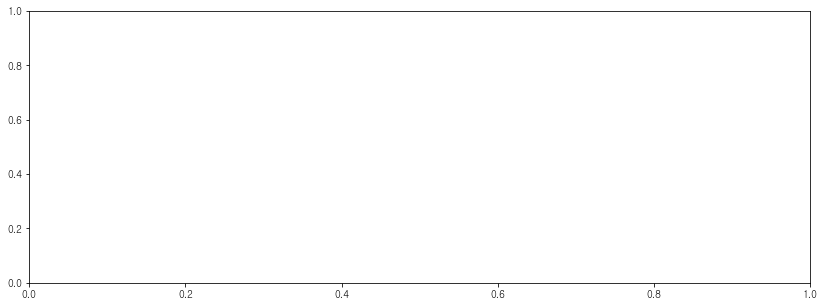

In [66]:
card_temp = card.copy()
fig, ax = plt.subplots(1,1,figsize=(14,5))
for i in range(0, len(set(card_temp['업종']))):
    if i//10 == 0:
        ax.plot(np.array(card_temp[card_temp['업종 중분류'] == kind[i]]['판매건수변환']),marker='o', linewidth=2,label=kind[i])
ax.legend()
ax.set_title('산업추이')

In [13]:
distance={}
for i in kind:
    try:         
        a=dtw.dtw(covid['확진자수변환'],card.loc[(card['업종 중분류']==i)]['판매건수변환']).distance
        distance[i]=a
        print(i,a)
    except:
        print('++++++++++++++\n',i,'error\n','+++++++++++++++++++++')

10 5.932641060809313
11 3.864045296500272
20 5.952023186330623
21 4.843927818227944
22 4.20458841005
30 4.314973292475463
31 5.153032770846948
32 5.9791644808168725
33 3.8123531497819374
34 3.5312051104712627
40 13.338771176611242
41 7.163388935185561
42 6.126384377349414
43 6.6236168538162605
44 3.892277667321641
50 4.125839662404688
51 5.962890008068316
52 6.571886780586868
60 9.68119565904612
61 4.2064156911271935
62 5.1582315134660055
70 11.11535786063381
71 4.154412309995168
80 10.553244613652456
81 7.3494805402731025
82 8.64595354666718
83 8.274270383952006
84 4.172679170836804
90 6.472349095168348
91 4.133776159798019
92 6.275712646691542
93 4.145467784800339
95 3.662465236484927
96 11.077753481101634
99 5.55809212177137


In [14]:
distance

{'10': 5.932641060809313,
 '11': 3.864045296500272,
 '20': 5.952023186330623,
 '21': 4.843927818227944,
 '22': 4.20458841005,
 '30': 4.314973292475463,
 '31': 5.153032770846948,
 '32': 5.9791644808168725,
 '33': 3.8123531497819374,
 '34': 3.5312051104712627,
 '40': 13.338771176611242,
 '41': 7.163388935185561,
 '42': 6.126384377349414,
 '43': 6.6236168538162605,
 '44': 3.892277667321641,
 '50': 4.125839662404688,
 '51': 5.962890008068316,
 '52': 6.571886780586868,
 '60': 9.68119565904612,
 '61': 4.2064156911271935,
 '62': 5.1582315134660055,
 '70': 11.11535786063381,
 '71': 4.154412309995168,
 '80': 10.553244613652456,
 '81': 7.3494805402731025,
 '82': 8.64595354666718,
 '83': 8.274270383952006,
 '84': 4.172679170836804,
 '90': 6.472349095168348,
 '91': 4.133776159798019,
 '92': 6.275712646691542,
 '93': 4.145467784800339,
 '95': 3.662465236484927,
 '96': 11.077753481101634,
 '99': 5.55809212177137}

In [15]:
max(distance.items(), key=operator.itemgetter(1))

('40', 13.338771176611242)

In [16]:
min(distance.items(), key=operator.itemgetter(1))

('34', 3.5312051104712627)

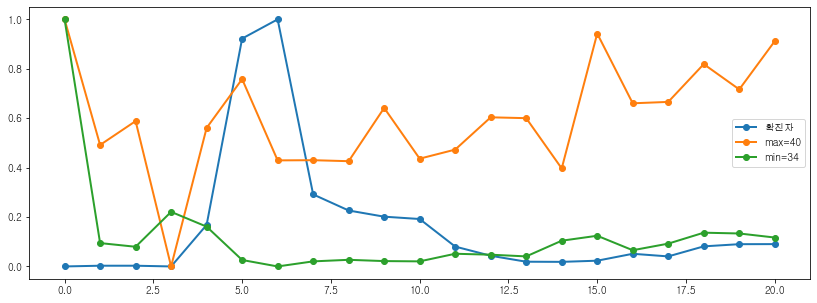

In [18]:
card_temp = card.copy()

fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '40']['판매건수변환']),marker='o', linewidth=2,label='max=40')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '34']['판매건수변환']),marker='o', linewidth=2,label='min=34')

ax.legend()

In [19]:
distance2={}
for i in kind:
    try:         
        a=dtw.dtw(covid['확진자수변환'],card.loc[(card['업종 중분류']==i)]['판매건수변환2']).distance

        distance2[i]=a
        print(i,a)
    except:
        print('++++++++++++++\n',i,'error\n','+++++++++++++++++++++')

10 13.06867429448678
11 12.210599669137505
20 11.081073653156517
21 14.443566549402753
22 14.059727114503323
30 12.584971191265808
31 6.032585930161134
32 8.14199898918519
33 10.828548741543637
34 12.163231319654447
40 4.096134979242942
41 9.05484326103044
42 10.047615933814456
43 6.975755299216496
44 12.330574024938057
50 13.050945429574114
51 8.256142085800997
52 6.597220583150519
60 9.80468791827337
61 11.764393897118474
62 9.054921069872503
70 5.688203849267424
71 12.677562200006843
80 5.696339151874178
81 12.806777078249901
82 12.657713696466518
83 9.90045051682712
84 12.90143932098798
90 9.567478873584795
91 10.56481272392716
92 7.654203995770157
93 13.371058530860395
95 9.758397098527233
96 8.569214733999651
99 10.337400138143002


In [20]:
max(distance2.items(), key=operator.itemgetter(1))

('21', 14.443566549402753)

In [21]:
min(distance2.items(), key=operator.itemgetter(1))

('40', 4.096134979242942)

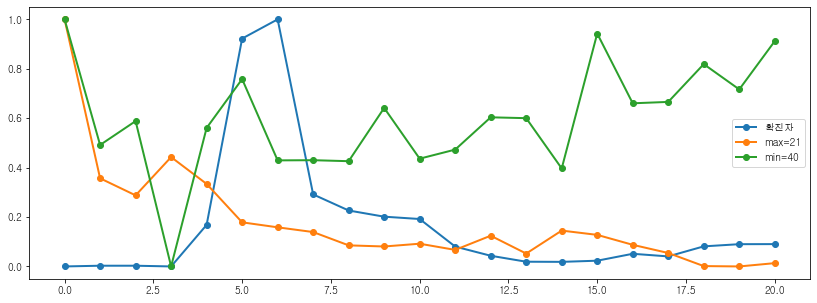

In [22]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '21']['판매건수변환']),marker='o', linewidth=2,label='max=21')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '40']['판매건수변환']),marker='o', linewidth=2,label='min=40')

ax.legend()

Text(0.5, 1.0, '산업추이')

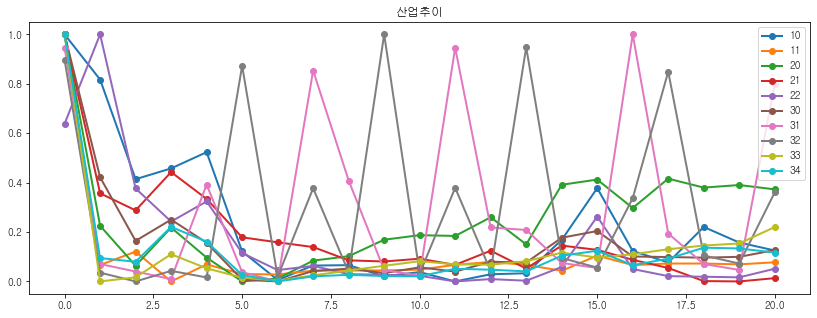

In [23]:
card_temp = card.copy()
fig, ax = plt.subplots(1,1,figsize=(14,5))
for i in range(0, len(set(card_temp['업종 중분류']))):
    if i//10 == 0:
        ax.plot(np.array(card_temp[card_temp['업종 중분류'] == kind[i]]['판매건수변환']),marker='o', linewidth=2,label=kind[i])
ax.legend()
ax.set_title('산업추이')

In [35]:

euclidean_dis={}
for i in kind: 
    a=euclidean(covid['확진자수변환'],card_temp.loc[(card_temp['업종 중분류']==i)]['판매건수변환'])

    euclidean_dis[i]=a
    print(i,a)


10 2.028891515495561
11 1.7091492631835274
20 1.9538228046525363
21 1.6779341872008187
22 1.8474369187799116
30 1.8198742937780588
31 2.320641951569313
32 2.066428823231803
33 1.7416274850527103
34 1.7517128706718272
40 2.5626208718100165
41 2.4442639296559814
42 1.9521103145195982
43 2.0665737271943447
44 1.7074922089175473
50 1.7331379993635425
51 2.4255433308620833
52 2.037574742676774
60 2.232388081583298
61 1.7331427861236028
62 2.244539962041683
70 2.515151573780548
71 1.8179606745017185
80 2.7001873363832862
81 1.9406207733300556
82 1.989130189934085
83 2.0010265253336375
84 1.7241843160791483
90 1.7366695045981233
91 1.6924101009556014
92 2.3845287420935546
93 1.7535717975987377
95 1.6477035596007783
96 2.4271905649270096
99 2.0757816921218537


In [36]:
max(euclidean_dis.items(), key=operator.itemgetter(1))

('80', 2.7001873363832862)

In [37]:
min(euclidean_dis.items(), key=operator.itemgetter(1))

('95', 1.6477035596007783)

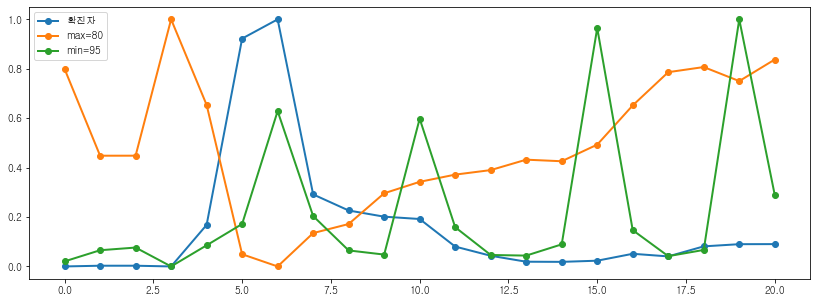

In [38]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '80']['판매건수변환']),marker='o', linewidth=2,label='max=80')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '95']['판매건수변환']),marker='o', linewidth=2,label='min=95')

ax.legend()

In [39]:
euclidean_dis2={}
for i in kind: 
    a=euclidean(covid['확진자수변환'],card.loc[(card['업종 중분류']==i)]['판매건수변환2'])

    euclidean_dis2[i]=a

print(euclidean_dis2)

10 3.103470310981817
11 3.6045641638676806
20 2.8636722822349334
21 3.3269098761208094
22 3.40972233923611
30 3.342355231963763
31 3.0280437475297246
32 3.2020743223510166
33 3.5078420639973555
34 3.5079189770613155
40 1.8798560293722597
41 2.0747755949103044
42 2.8635300153039243
43 2.85895107329987
44 3.680936542621639
50 3.6994478576243663
51 2.786736566412166
52 2.828404882420848
60 2.106217337447508
61 3.4119767092329862
62 2.866322529086132
70 1.8912730594550626
71 3.3107214098321247
80 1.860794851973487
81 2.810818677703439
82 2.290333375864795
83 2.4311012897641473
84 3.736215564261683
90 2.761737578667897
91 3.4116612001604265
92 2.3395540916130577
93 3.441059028346548
95 3.41844109933189
96 2.237486030740639
99 2.6798736099759397


In [40]:
max(euclidean_dis2.items(), key=operator.itemgetter(1))

('84', 3.736215564261683)

In [41]:
min(euclidean_dis2.items(), key=operator.itemgetter(1))

('80', 1.860794851973487)

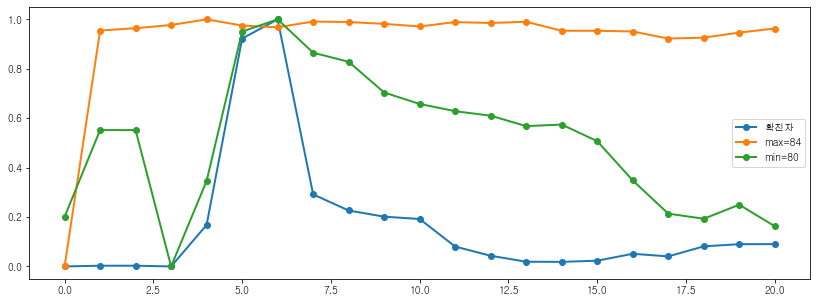

In [42]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '84']['판매건수변환2']),marker='o', linewidth=2,label='max=84')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '80']['판매건수변환2']),marker='o', linewidth=2,label='min=80')

ax.legend()

In [43]:
category2 =[str(61),str(31),str(20),str(33), str(11), str(83) , str(52) , str(95)  , str(96) , str(42) , str(80) , str(40) , str(62) , str(70) , str(50), str(92),str(10) ]

In [44]:
euclidean_dis={}
for i in category2: 
    try:
        a=euclidean(covid['확진자수변환'],card.loc[(card['업종 중분류']==i)]['판매건수변환'])

        euclidean_dis[i]=a
        print(i,a)
    except:
        print('error\n',i,'error\n')

61 1.7331427861236028
31 2.320641951569313
20 1.9538228046525363
33 1.7416274850527103
11 1.7091492631835274
83 2.0010265253336375
52 2.037574742676774
95 1.6477035596007783
96 2.4271905649270096
42 1.9521103145195982
80 2.7001873363832862
40 2.5626208718100165
62 2.244539962041683
70 2.515151573780548
50 1.7331379993635425
92 2.3845287420935546
10 2.028891515495561


In [45]:
max(euclidean_dis.items(), key=operator.itemgetter(1))

('80', 2.7001873363832862)

In [46]:
min(euclidean_dis.items(), key=operator.itemgetter(1))

('95', 1.6477035596007783)

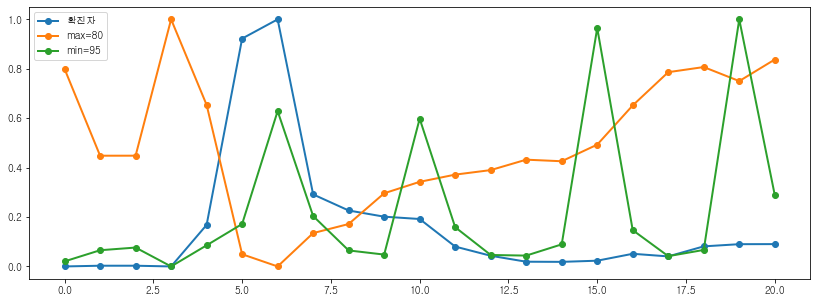

In [53]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '80']['판매건수변환']),marker='o', linewidth=2,label='max=80')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '95']['판매건수변환']),marker='o', linewidth=2,label='min=95')

ax.legend()

In [47]:
euclidean_dis2={}
for i in category: 
    try:
        a=euclidean(covid['확진자수변환'],card.loc[(card['업종 중분류']==i)]['판매건수변환2'])

        euclidean_dis2[i]=a
        print(i,a)
    except:
        print('error\n',i,'error\n')

83 2.4311012897641473
80 1.860794851973487
71 3.3107214098321247
40 1.8798560293722597
82 2.290333375864795
42 2.8635300153039243
21 3.3269098761208094
20 2.8636722822349334
10 3.103470310981817
70 1.8912730594550626
51 2.786736566412166
61 3.4119767092329862
44 3.680936542621639
91 3.4116612001604265
22 3.40972233923611
81 2.810818677703439
84 3.736215564261683
52 2.828404882420848
31 3.0280437475297246
34 3.5079189770613155
50 3.6994478576243663
99 2.6798736099759397
11 3.6045641638676806
43 2.85895107329987
92 2.3395540916130577
33 3.5078420639973555
93 3.441059028346548
62 2.866322529086132
30 3.342355231963763
60 2.106217337447508
90 2.761737578667897
32 3.2020743223510166
41 2.0747755949103044
96 2.237486030740639
95 3.41844109933189


In [48]:
max(euclidean_dis2.items(), key=operator.itemgetter(1))

('84', 3.736215564261683)

In [49]:
min(euclidean_dis2.items(), key=operator.itemgetter(1))

('80', 1.860794851973487)

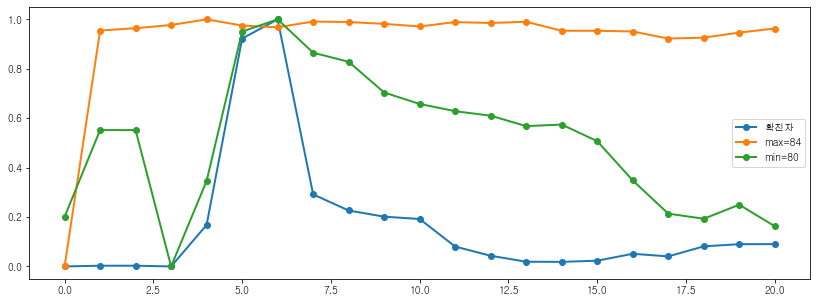

In [51]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
ax.plot(np.array(covid['확진자수변환']),marker='o', linewidth=2,label='확진자')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '84']['판매건수변환2']),marker='o', linewidth=2,label='max=84')
ax.plot(np.array(card_temp[card_temp['업종 중분류'] == '80']['판매건수변환2']),marker='o', linewidth=2,label='min=80')

ax.legend()

영향 많이 받는거 : 군집코드 :  80

품목 : ['스넥' '주점' '서양음식' '중국음식' '일식회집' '일반한식' '칵테일바' '위탁급식업' '갈비전문점' '한정식']

영향 덜 받는거 : 군집코드 : 84

품목 : ['인삼 제품' '홍삼 제품' '기타건강식']

군집코드 :  95

품목 : 
 ['통신판매(일반)' '통신판매(생활서비스)']